In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://zenn.dev/pharmax/articles/8796b892eed183',
  'content': 'Nodeは、Graph上で実際のステップを実行するコンポーネントです。例えば実際にLangChainを使用してLLMのモデルを呼び出す処理は、Node上で行います。\n\nNodeでは、`(State、Config) -> 変更するState`というシグネチャを持つ関数を使うことができます。 [...] | コンポーネント | 説明 |\n| --- | --- |\n| Graph | LangGraphの中核となる構成要素で、各NodeとEdgeの集合体です。 |\n| State | ノード間の遷移の際に保持される情報で、各ノードが参照および更新します。 |\n| Node | グラフ内の個々のステップや状態を表す要素で、特定のアクションやチェックポイントとして機能します。 |\n| Edge | ノード間の接続を表し、遷移の条件やアクションを定義します。条件付きエッジなど、特定のロジックに基づいて遷移を制御できます。 |\n\n## Graph\n\nGraphは、LangGraphの中核となるグラフ全体を管理するためのコンポーネントです。基本的な使い方としては、`StateGraph`というクラスを使い、後述するStateとセットで初期化します。\n\n`StateGraph`\n\n（StateGraphの宣言例）'},
 {'url': 'https://www.supinf.co.jp/tech-blog/details/about-langgraph/',
  'content': '| å\x90\x8då\x89\x8d | èª¬æ\x98\x8e |\n| --- | --- |\n| name | `Edge` ã\x82\x92è¿½å\x8a ã\x81\x99ã\x82\x8bã\x81¨ã\x81\x8dã\x81« `Node` ã\x82\x92å\x8f\x82ç\x85§ã\x81\x99ã\x82\x8bã\x81\x9fã\x82\x81ã\x81®æ\x96\x87å\xad\x97å\x88\x97ã\x80\x82 |\n| value | å\x91¼ã\x81³

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

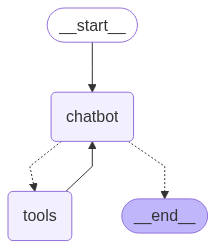

In [6]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！今日はどんなことをお手伝いできますか？
1足す2は？
1足す2は3です。何か他に質問がありますか？
1メートル以上の魚は？

[{"url": "https://tsurihack.com/1870", "content": "LINE公式アカウント 最新の釣り情報をチェック！ 友だち追加はこちら\n![TSURI HACK[釣りハック]](\nMENU\n日本三大怪魚の画像\n\n# 日本三大怪魚とは？その種類と特徴、釣ることはできるのか！\n\n日本三大怪魚。1メートルを超える巨大な魚体と、希少さから釣り人から幻の魚ともよばれる3種。大型魚に魅了された怪魚ハンターの様に、釣ってみたいと考える方もいらっしゃるのではないでしょうか。今回、日本三大怪魚の各種をご紹介します。\n\n2023/06/20 更新\n\n本ページはアフィリエイトプログラムを利用しています。\n\nTSURI HACK編集部\n\n編集者\n\nTSURI HACK編集部\n\n釣り歴20年のTSURI HACK運営＆記事編集担当。年間1000を超える記事を配信するため、海から川・湖、エサ釣りからルアーまで幅広い釣り用品に触れています。公式SNSでも最新情報から編集部のインプレッションまで絶賛配信中！\n\nAngler@ライター\n\n制作者\n\nAngler@ライター [...] 渓流からバス釣り、シーバス、ロックフィッシュ、五目釣りからチヌのヘチ釣りまで、ジャンルを問わず関東地方のフィールドを釣り歩いています。子供の頃から大の釣り好き。今までの経験を元に釣りの楽しさや魅力を多くの人に伝えていきたいと思っています。よろしくお願いいたします。\n\n目次\n\n## 日本三大怪魚とは\n\nクエッションの画像\n\nクエッションの画像\n\n日本の限られた地域にのみ生息し、1メートルを超える大型に成長する「日本三大怪魚」。その稀少さと見た目から、国内では絶滅危惧類として指定される魚もいるほど。\n\n釣り人であればそんな夢の魚を一度は釣ってみたいのではないでしょうか。ここでは、三大怪魚を一種ずつご紹介し、狙い方などを説明いたします。\n\n日本怪魚をハンティングする密着DVD！  \n\n日本怪魚物語 Vol.1\n\nに指定されています。\n\n東南アジア近隣に